# Исследование DMatrix

__Важная концептуальная информация про отличия интерфейса XGBoost и Sklearn:__  
https://overcoder.net/q/572033/%D1%80%D0%B0%D0%B7%D0%BB%D0%B8%D1%87%D0%B8%D0%B5-%D0%BC%D0%B5%D0%B6%D0%B4%D1%83-%D0%BE%D1%80%D0%B8%D0%B3%D0%B8%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%BC-xgboost-%D0%B8-sklearn-xgbclassifier  

__Подбор гиперпараметров для повторяемости результата:__  
https://github.com/dmlc/xgboost/issues/4637  

__Examples:__  
https://xgboost.readthedocs.io/en/latest/get_started.html  

__Более глубокое объяснение разницы:__  
https://overcoder.net/q/886228/%D0%B2-%D1%87%D0%B5%D0%BC-%D1%80%D0%B0%D0%B7%D0%BD%D0%B8%D1%86%D0%B0-%D0%BC%D0%B5%D0%B6%D0%B4%D1%83-xgbtrain-%D0%B8-xgbxgbregressor-%D0%B8%D0%BB%D0%B8-xgbxgbclassifier

### Чтение данных

In [1]:
fs = [...] # список признаков, конфиденциально

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
table = pd.read_csv('table_fe.csv', sep='`', encoding='cp1251', low_memory=False) 
atable = pd.read_csv('atable_fe.csv', sep='`', encoding='cp1251', low_memory=False)    

In [4]:
table = table[fs]  
atable = atable[fs]

In [5]:
y_train = pd.read_csv('y_train.csv', sep='`', encoding='cp1251', low_memory=False) 
y_test = pd.read_csv('y_test.csv', sep='`', encoding='cp1251', low_memory=False)  

## Настройка параметров

### Baseline со SKlearn 

In [6]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report 
from sklearn.model_selection import GridSearchCV

In [7]:
clf = XGBClassifier(objective='binary:logistic',
                    eval_metric=['auc', 'error'],
                    max_depth=1,
                    learning_rate=0.1)  

clf.fit(table, y_train)

C:\Users\ntrifonov\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              eval_metric=['auc', 'error'], gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [8]:
pred_scr = clf.predict_proba(atable)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred_scr)
roc_auc = roc_auc_score(y_test, pred_scr)
Gini = round(2*round(float(roc_auc),4)-1,4)
Gini

0.3418

In [9]:
pred_scr_o = clf.predict_proba(table)[:, 1]
fpr_o, tpr_o, thresholds_o = roc_curve(y_train, pred_scr_o)
roc_auc_o = roc_auc_score(y_train, pred_scr_o)
Gini_o = round(2*round(float(roc_auc_o),4)-1,4)
Gini_o

0.3766

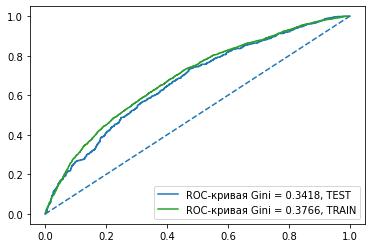

In [10]:
plt.plot(fpr, tpr, label='ROC-кривая Gini = %0.4f, TEST' % (Gini), color='tab:blue')
plt.plot(fpr_o, tpr_o, label='ROC-кривая Gini = %0.4f, TRAIN' % (Gini_o), color='tab:green')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1] , linestyle='--')

### Сравним с DMatrix

#### Здесь долго мучался с результатом, он отличался на 20%, обратим внимание на num_boost_round

In [11]:
import xgboost as xgb
# read the data
dtrain = xgb.DMatrix(table, label=y_train)
dtest = xgb.DMatrix(atable, label=y_test)
# specify parameters via map
"""
params = {
    'objective':'binary:logistic',objective='binary:logistic',
    'eval_metric':['auc', 'error'],
    'max_depth': 1,
    'learning_rate': 0.1
    }
"""
# параметры по инструкции выше не подошли, видимо, библиотека новая
# воспользуемсятпараметрами выше, в модели sklearn
params = {  'objective':'binary:logistic',
            'base_score':0.5,
            'booster':'gbtree', 
            'colsample_bylevel':1,
            'colsample_bynode':1,
            'colsample_bytree':1,
            'eval_metric':['auc', 'error'], 
            'gamma':0,
            'gpu_id':-1,
            #'importance_type':'gain',
            'interaction_constraints':'',
            'learning_rate':0.1,
            'max_delta_step':0,
            'max_depth':1,
            'min_child_weight':1,
            #'missing':nan,
            'monotone_constraints':'()',
            #'n_estimators':100,
            'n_jobs':0,
            'num_parallel_tree':1,
            'random_state':0,
            'reg_alpha':0,
            'reg_lambda':1,
            'scale_pos_weight':1,
            'subsample':1,
            'tree_method':'exact',
            'validate_parameters':1,
            'verbosity':None
        }

num_boost_round = 100 # !!! вот в чем дело было!!! - это аналог n_estimators в sklearn
bst = xgb.train(params, dtrain, num_boost_round)

# make prediction
preds = bst.predict(dtest)

In [12]:
#pred_scr_o = clf.predict_proba(table)[:, 1]
pred_scr_o = preds
fpr_o, tpr_o, thresholds_o = roc_curve(y_test, pred_scr_o)
roc_auc_o = roc_auc_score(y_test, pred_scr_o)
Gini_o = round(2*round(float(roc_auc_o),4)-1,4)
Gini_o

0.3418

In [13]:
pred_scr_o = bst.predict(dtrain)
fpr_o, tpr_o, thresholds_o = roc_curve(y_train, pred_scr_o)
roc_auc_o = roc_auc_score(y_train, pred_scr_o)
Gini_o = round(2*round(float(roc_auc_o),4)-1,4)
Gini_o

0.3766

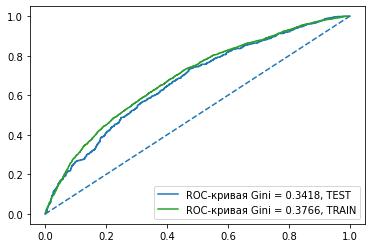

In [14]:
plt.plot(fpr, tpr, label='ROC-кривая Gini = %0.4f, TEST' % (Gini), color='tab:blue')
plt.plot(fpr_o, tpr_o, label='ROC-кривая Gini = %0.4f, TRAIN' % (Gini_o), color='tab:green')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1] , linestyle='--')

## Сравнение времени работы

In [15]:
from time import process_time

In [16]:
time_mean_str_sk = 0 #sklearn
time_std_str_sk = 0

tmp = []
for i in range(10): # число циклов
    t = process_time()

    for j in range(10): # по 10 итерациям объективнее обучать
        
        clf.fit(table, y_train)
        
    elapsed_time = process_time() - t
    tmp.append(elapsed_time)
        
time_mean_str_sk = (np.mean(tmp)/10) # считаем на одну итерацию обучения
time_std_str_sk = (np.std(tmp)/10) # считаем на одну итерацию обучения

C:\Users\ntrifonov\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [17]:
time_mean_str_xgb= 0 #xgb
time_std_str_xgb = 0

tmp = []
for i in range(10): # число циклов
    t = process_time()

    for j in range(10): # по 10 итерациям объективнее обучать
        
        xgb.train(params, dtrain, num_boost_round)
        
    elapsed_time = process_time() - t
    tmp.append(elapsed_time)
        
time_mean_str_xgb = (np.mean(tmp)/10) # считаем на одну итерацию обучения
time_std_str_xgb = (np.std(tmp)/10) # считаем на одну итерацию обучения

In [18]:
print('Sklearn: ', time_mean_str_sk,' +/- ',  time_std_str_sk)
print('XGB with DMatrix: ', time_mean_str_xgb,' +/- ',  time_std_str_xgb)

Sklearn:  1.5557812500000001  +/-  0.02682817505091429
XGB with DMatrix:  1.4421875  +/-  0.015609367179677721


In [20]:
time_mean_str_xgb/time_mean_str_sk

0.926986039971879

## Вывод

Использование DMatrix дало выйгрыш во времени примерно в 8%.  
При вычислительно затратных операциях, например кросс-валидации и переборе гиперпараметров это может быть весьма актуально.